# Real-time video segmentation

This notebook illustrates the use of the two video datasets. One loads a video from file in a frame-by-frame fashion. We train a model this way, and then create an output video file with the inferred tools superposed on the input video. The data used here is from the EndoVis challenge.

After that, we use the `CameraDataset`, which uses a capture device as detected by OpenCV. This could be a webcam, for example. We use the previous model, which gives non-sensical results, since it was trained on an endoscopy video, rather than a webcam, but should highlight what is possible.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/modules/video_seg.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, ignite, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import cv2" || pip install -q opencv-python
%matplotlib inline

## Imports

In [2]:
# Copyright 2022 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from IPython.display import Video, clear_output
from torch.utils.data import Dataset
import cv2
import os
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
import torch

import monai
from monai.visualize.utils import blend_images
from monai.data.video_dataset import VideoFileDataset, CameraDataset
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
import monai.transforms as mt
from monai.utils import set_determinism
from monai.apps import download_url

monai.config.print_config()

# Set deterministic training for reproducibility
set_determinism(seed=0)

MONAI version: 0.9.1+4.g82d58e4a.dirty
Numpy version: 1.22.3
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 2d52bfe27e7dd2f238103cc32f8f1837c1fa8214
MONAI __file__: /mnt/data/rbrown/Documents/Code/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.1
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.9.1
gdown version: 4.4.0
TorchVision version: 0.11.3
tqdm version: 4.64.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.1.5
einops version: 0.4.0
transformers version: 4.14.1
mlflow version: 1.23.1
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)
endo_dir = os.path.join(root_dir, "endo_vid")

/home/rich/Documents/Data/MONAI


## Download data

The data here are a short endoscopic video from the EndoVis 2017 grand challenge. The video consists of just 23 frames. The corresponding ground truth segmentation is a binary labelfield, with tools marked as foreground and everything else marked as background.

In [4]:
vid_url = "https://github.com/rijobro/real_time_seg/raw/main/example_data/EndoVis2017/d1_im.mp4"
vid_hash = "9b103c07326439b0ea376018d7189384"
seg_url = "https://github.com/rijobro/real_time_seg/raw/main/example_data/EndoVis2017/d1_seg.mp4"
seg_hash = "da4eb17b6f8e4155fd81b962d46e5eff"
vid_filepath = os.path.join(endo_dir, "endo.mp4")
seg_filepath = os.path.join(endo_dir, "endo_seg.mp4")

download_url(vid_url, vid_filepath, vid_hash)
download_url(seg_url, seg_filepath, seg_hash)

2022-08-01 10:05:04,630 - INFO - Verified 'endo.mp4', md5: 9b103c07326439b0ea376018d7189384.
2022-08-01 10:05:04,631 - INFO - File exists: /home/rich/Documents/Data/MONAI/endo_vid/endo.mp4, skipped downloading.
2022-08-01 10:05:04,632 - INFO - Verified 'endo_seg.mp4', md5: da4eb17b6f8e4155fd81b962d46e5eff.
2022-08-01 10:05:04,632 - INFO - File exists: /home/rich/Documents/Data/MONAI/endo_vid/endo_seg.mp4, skipped downloading.


## Transforms, datasets and dataloader

Our transforms ensure that the image is divisible by a factor required by our network. We then scale the intensity of our image between 0 and 1 and convert to float. Our ground truth segmentation is the same, except we also flatten the RGB frame to a single channel.

For the dataset, we use two instances of `VideoFileDataset`, one for the input video and the other for the ground truth segmentations. We create a `CombinedVidDataset` that enables us to iterate across these two at the same time.

The data loader is the standard.

In [5]:
vid_transforms = mt.Compose(
    [
        mt.DivisiblePad(16),
        mt.ScaleIntensity(),
        mt.CastToType(torch.float32),
    ]
)
seg_transforms = mt.Compose([vid_transforms, mt.Lambda(lambda x: x[:1])])  # rgb -> 1 chan


class CombinedVidDataset(Dataset):
    def __init__(self, img_file, seg_file, vid_transforms, seg_transforms):
        self.ds_img = VideoFileDataset(vid_filepath, vid_transforms)
        self.ds_lbl = VideoFileDataset(seg_filepath, seg_transforms)

    def __len__(self):
        return len(self.ds_img)

    def __getitem__(self, idx):
        return {"image": self.ds_img[idx], "label": self.ds_lbl[idx]}


ds = CombinedVidDataset(vid_filepath, seg_filepath, vid_transforms, seg_transforms)
dl = DataLoader(ds, batch_size=3, num_workers=0, shuffle=True)

print(f"Number of frames in vid: {len(ds)}")

Number of frames in vid: 23


## Show selection

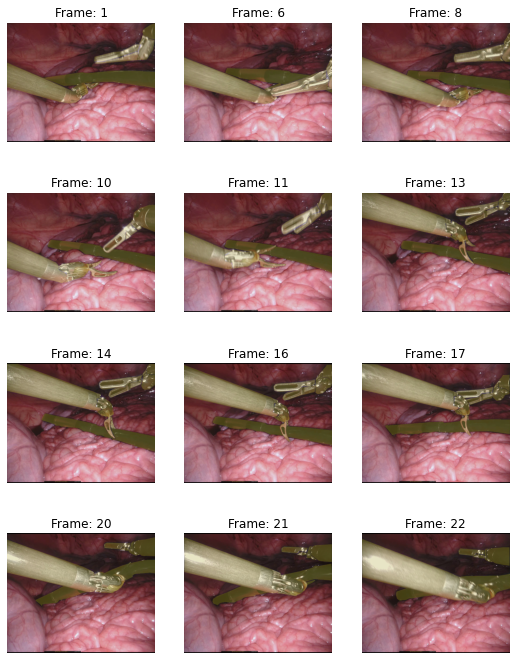

In [6]:
nrow, ncol = 4, 3
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * 3, nrow * 3), facecolor='white')
nexamples = nrow * ncol
frames = sorted(np.random.choice(len(ds), size=nexamples, replace=False))
for frame, ax in zip(frames, axes.flatten()):
    _ds = ds[frame]
    img, lbl = _ds["image"], _ds["label"]
    blended = blend_images(img, lbl, cmap="viridis", alpha=0.2)
    blended = np.moveaxis(blended, 0, -1)  # RGB to end
    ax.imshow(blended)
    ax.set_title(f"Frame: {frame}")
    ax.axis("off")

## Training parameters

We use vanilla segmentation training parameters -- UNet, Dice and Adam.

In [7]:
# Create network, loss fn., etc.
dice_metric = DiceMetric(reduction="mean")
post_trans = mt.Compose([
    mt.Activations(sigmoid=True),
    mt.AsDiscrete(threshold=0.5),
])
in_channels = ds[0]["image"].shape[0]
# create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=2,
    in_channels=in_channels,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
loss_function = DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-2)

## Normal training loop

Loss: 0.1057: 100%|██████████████████████████████████████████████████████| 20/20 [00:54<00:00,  2.71s/it]


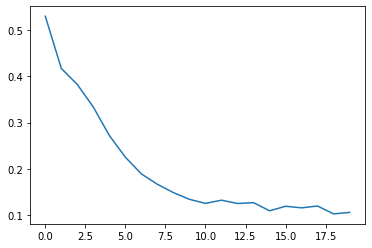

In [8]:
best_model_path = "best_model_video_seg.pth"

# start a typical PyTorch training
max_epochs = 20
val_interval = 1
best_metric = -1
best_metric_epoch = -1
losses = []

tr = trange(max_epochs)
for _ in tr:
    model.train()
    epoch_loss = 0

    for batch_data in dl:
        inputs, labels = batch_data["image"].to(
            device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(dl)
    losses.append(epoch_loss)
    tr.set_description(f"Loss: {epoch_loss:.4f}")

_ = plt.plot(losses)

# Check segmentations

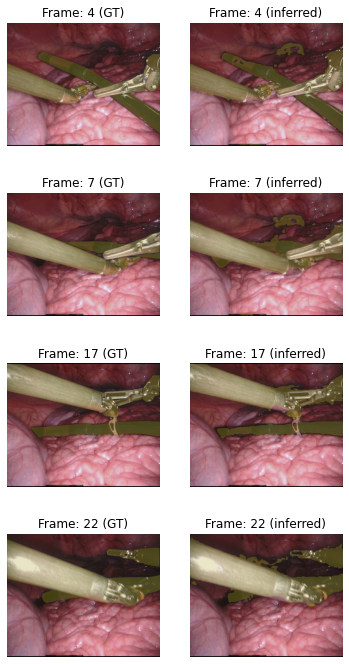

In [9]:
def infer_seg(im, model):
    """Infer single model and threshold."""
    inferred = model(im[None]) > 0
    return inferred[0].detach()


nrow, ncol = 4, 2
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * 3, nrow * 3), facecolor='white')
nexamples = nrow
frames = sorted(np.random.choice(len(ds), size=nexamples, replace=False))
for row, frame in enumerate(frames):
    _ds = ds[frame]
    img, lbl = _ds["image"], _ds["label"]
    inferred = infer_seg(img.to(device), model).cpu()
    for col, (_lbl, title) in enumerate(zip((lbl, inferred), ("GT", "inferred"))):
        blended = blend_images(img, _lbl, cmap="viridis", alpha=0.2)
        blended = np.moveaxis(blended, 0, -1)  # RGB to end
        axes[row, col].imshow(blended)
        axes[row, col].set_title(f"Frame: {frame} ({title})")
        axes[row, col].axis("off")

## Generating video

In [10]:
codecs = VideoFileDataset.get_available_codecs()
codec, ext = next(iter(codecs.items()))
print(codec, ext)

mp4v .mp4


[ERROR:0@75.928] global /io/opencv/modules/videoio/src/cap_ffmpeg_impl.hpp (2927) open Could not find encoder for codec_id=27, error: Encoder not found
[ERROR:0@75.928] global /io/opencv/modules/videoio/src/cap_ffmpeg_impl.hpp (3002) open VIDEOIO/FFMPEG: Failed to initialize VideoWriter
[ERROR:0@75.928] global /io/opencv/modules/videoio/src/cap.cpp (595) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /io/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): /tmp/tmp0fai7rzf/test.avi in function 'icvExtractPattern'


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
[ERROR:0@75.928] global /io/opencv/modules/videoio/src/cap_ffmpeg_impl.hpp (2927) open Could not find encoder for codec_id=27, error: Encoder not found
[ERROR:0@75.928] global /io/opencv/modules/videoio/src/cap_ffm

In [11]:
def create_video(ds, output_file, fps, codec, ext, check_codec=True):
    fourcc = cv2.VideoWriter_fourcc(*codec)
    if check_codec:
        codec_success = cv2.VideoWriter().open("test" + ext, fourcc, 1, (10, 10))
        if not codec_success:
            raise RuntimeError("failed to open video.")
        os.remove("test" + ext)

    print(f"{len(ds)} frames @ {fps} fps: {output_file}...")
    for idx in trange(len(ds)):
        img = ds[idx]["image"]
        inferred = infer_seg(img.to(device), model).detach().cpu()
        blended = blend_images(img, inferred, cmap="viridis", alpha=0.2)
        if idx == 0:
            width_height = blended.shape[1:][::-1]
            video = cv2.VideoWriter(output_file, fourcc, fps, width_height)
        blended = (np.moveaxis(blended, 0, -1) * 254).astype(np.uint8)
        blended = cv2.cvtColor(blended, cv2.COLOR_RGB2BGR)
        video.write(blended)
    video.release()
    if not os.path.isfile(output_file):
        raise RuntimeError("video not created:", output_file)
    print("Success!")


fps = ds.ds_img.get_fps()
inferred_vid = os.path.join(endo_dir, "inferred.mp4")
create_video(ds, inferred_vid, fps, codec, ext)

23 frames @ 2.0 fps: /home/rich/Documents/Data/MONAI/endo_vid/inferred.mp4...


100%|████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.22it/s]

Success!


In [12]:
Video(inferred_vid, embed=True, height=300)

In [13]:
num_capture_devices = CameraDataset.get_num_devices()
if num_capture_devices == 0:
    print("This part requires a local capture device (e.g., webcam)")
else:
    cam_transforms = mt.Compose([
        mt.DivisiblePad(16),
        mt.ScaleIntensity(),
    ])
    if "cam_ds" in locals():
        del cam_ds
    cam_ds = CameraDataset(0, cam_transforms, max_num_frames=None)

    time_limit = 60  # time limit in s
    plt.figure()
    start_time = time.time()
    for frame in cam_ds:
        inferred = infer_seg(frame.to(device).float(), model).detach().cpu()
        blended = blend_images(frame, inferred, cmap="viridis", alpha=0.2)
        blended = np.moveaxis(blended, 0, -1)  # RGB to end
        plt.imshow(blended)
        plt.axis('off')
        plt.show()
        clear_output(wait=True)
        _ = time.sleep(0.1)
        if time.time() - start_time > time_limit:
            break